In [4]:
!pip install pydicom
!pip install pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg
!apt-get install -y libgdcm-dev
!pip install gdcm
!pip install opencv-python opencv-python-headless


import pydicom
from PIL import Image
import matplotlib.pyplot as plt
from pydicom import dcmread
from pydicom.data import get_testdata_file
import os
import numpy as np
import cv2


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [5]:
path = '/home/shihab/Desktop/Machine Learning/Dataset/3dImageDataset/147-Tahera Sultana. Dr_Nurul_Amin/00000000.dcm'


In [7]:
# Before reading the DICOM file, try setting the decoding plugin explicitly
try:
    # Try pylibjpeg first
    pydicom.config.image_handlers = ['pylibjpeg']
    ds = dcmread(path)
except Exception as e:
    try:
        # If pylibjpeg fails, try gdcm
        pydicom.config.image_handlers = ['gdcm']
        ds = dcmread(path)
    except Exception as e:
        print(f"Error: Could not decode pixel data. Please ensure the required dependencies are installed.\n{e}")

# ... (rest of the code) ...

Patient's Name...: Tahera Sultana, 
Patient ID.......: 000147
Modality.........: CT
Study Date.......: 20240828
Image size.......: 600 x 600
Pixel Spacing....: [0.2, 0.2]
Slice location...: 0


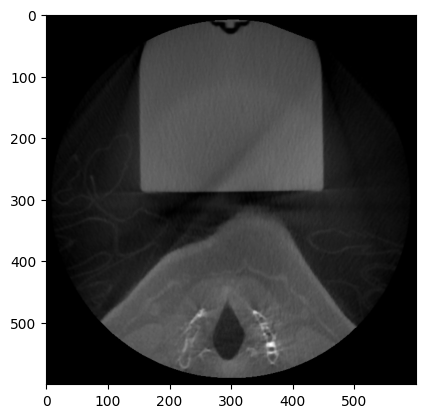

In [8]:
ds = dcmread(path)

pat_name = ds.PatientName
print(f"Patient's Name...: {pat_name.family_comma_given()}")
print(f"Patient ID.......: {ds.PatientID}")
print(f"Modality.........: {ds.Modality}")
print(f"Study Date.......: {ds.StudyDate}")
print(f"Image size.......: {ds.Rows} x {ds.Columns}")
print(f"Pixel Spacing....: {ds.PixelSpacing}")

# use .get() if not sure the item exists, and want a default value if missing
print(f"Slice location...: {ds.get('SliceLocation', '(missing)')}")



# plot the image using matplotlib
plt.imshow(ds.pixel_array, cmap=plt.cm.gray)
plt.show()